In [35]:
import numpy as np
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from Code.fixed_income_derivatives_E2024 import *
from scipy.optimize import minimize
from scipy.stats import norm, gamma

$$
(T-t)^2 = T^2 + t^2 -2Tt
$$
$$
(T-t)^3 = T^3 - t^3 + 3Tt^2 - 3T^2t
$$
$$
\int_t^T \frac{\partial f^*(0,s)}{\partial s}s ds =
f^*(0,T)T - f^*(0,t)t - f^*(0,T) + f^*(0,t)
$$
$$
\int_t^T \Theta(s)(s-T)ds = f^*(0,t)(T-t)+f^*(0,t)-f^*(0,T)\\
+\frac{3\sigma^2t^2T-\sigma^2T^3-2\sigma^2t^3}{6}
$$
$$
A(t,T)=f^*(0,t)(T-t)+f^*(0,t)-f^*(0,T)\\
+\frac{6\sigma^2t^2T-3\sigma^2t^3-3T^2t}{6}
$$
$$
A(t,T)=f^*(0,t)(T-t)+f^*(0,t)-f^*(0,T)-\frac{\sigma^2}{2}t(T-t)^2
$$

In [36]:
#3.a)
EURIBOR_fixing = [
{"id": 0,"instrument": "libor","maturity": 1/2, "rate":0.0430136}]
fra_market = [
{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate":  0.0455066},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate":  0.0477436},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate":  0.0497492},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.0515456},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.0531529},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.0545893},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.0558712},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.0570135},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.0580298}]
swap_market = [
{"id": 10,"instrument": "swap","maturity": 2, "rate":  0.0558702, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate":  0.058811, "float_freq": "semiannual",  "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate":  0.0600937, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate":  0.0605263, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate":  0.0601899, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.0586669, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.0562267, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.0547351, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.0535523, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data = EURIBOR_fixing + fra_market + swap_market
interpolation_options = {"method":"nelson_siegel", "transition": "smooth"}
T_fit, R_fit = zcb_curve_fit(data,interpolation_options = interpolation_options)
T_6m = np.array([i*1/12 for i in range(0,30*12 + 1)])
p_inter, R_inter, f_inter, T_inter = zcb_curve_interpolate(T_6m,T_fit,R_fit,interpolation_options = interpolation_options)

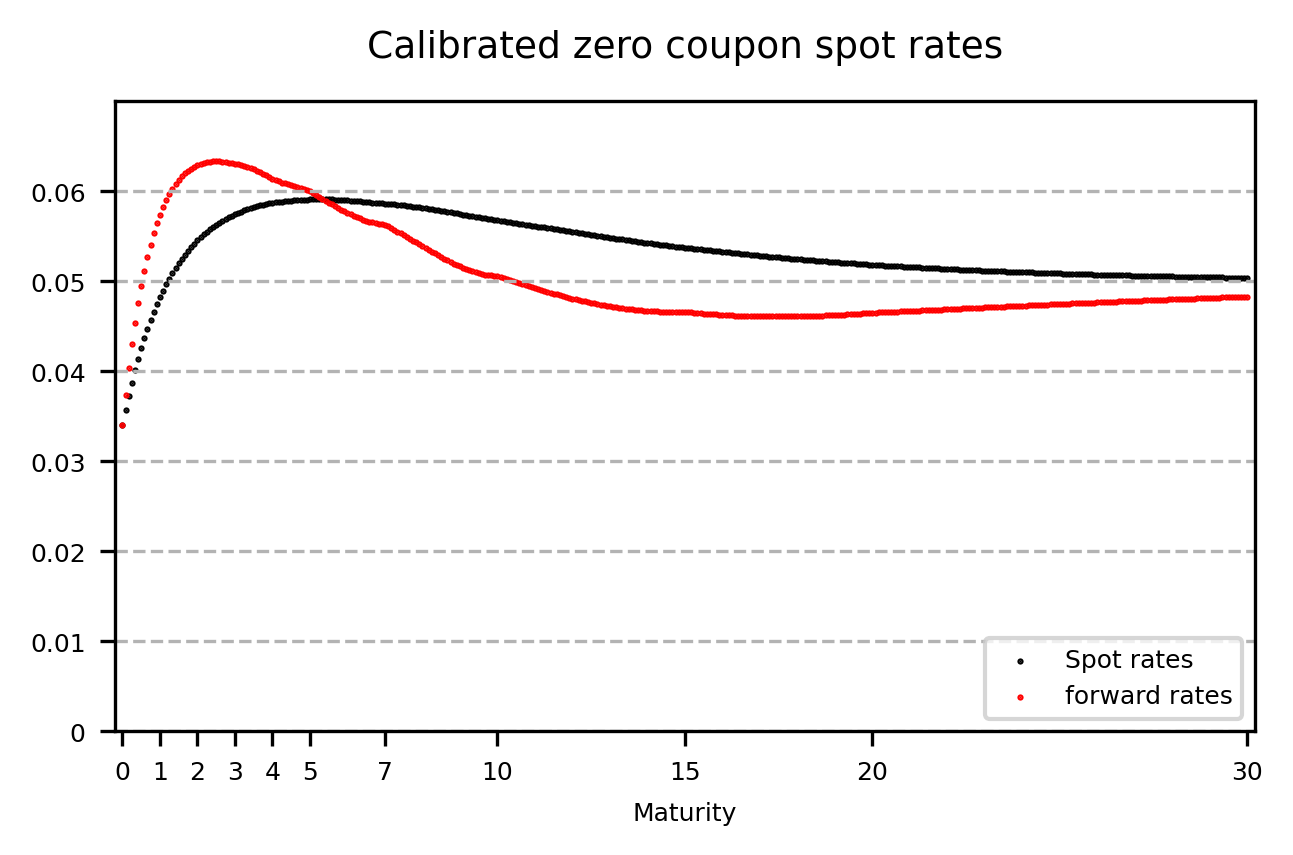

In [37]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.07])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

In [38]:
#It looks smooth and differentiable which are the properties we want

In [39]:
#3.b)
r0 = 0.035
a = 0.5
b = 0.025
sigma = 0.03
param_0 = r0, a, b, sigma
result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})
r0_fit, a_fit, b_fit, sigma_fit = result.x

/var/folders/rh/hgh0t3z125qcsw17t8sbyckw0000gn/T/ipykernel_72933/996152511.py:7: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R_inter,T_inter),options={'xatol': 1e-20,'disp': True})


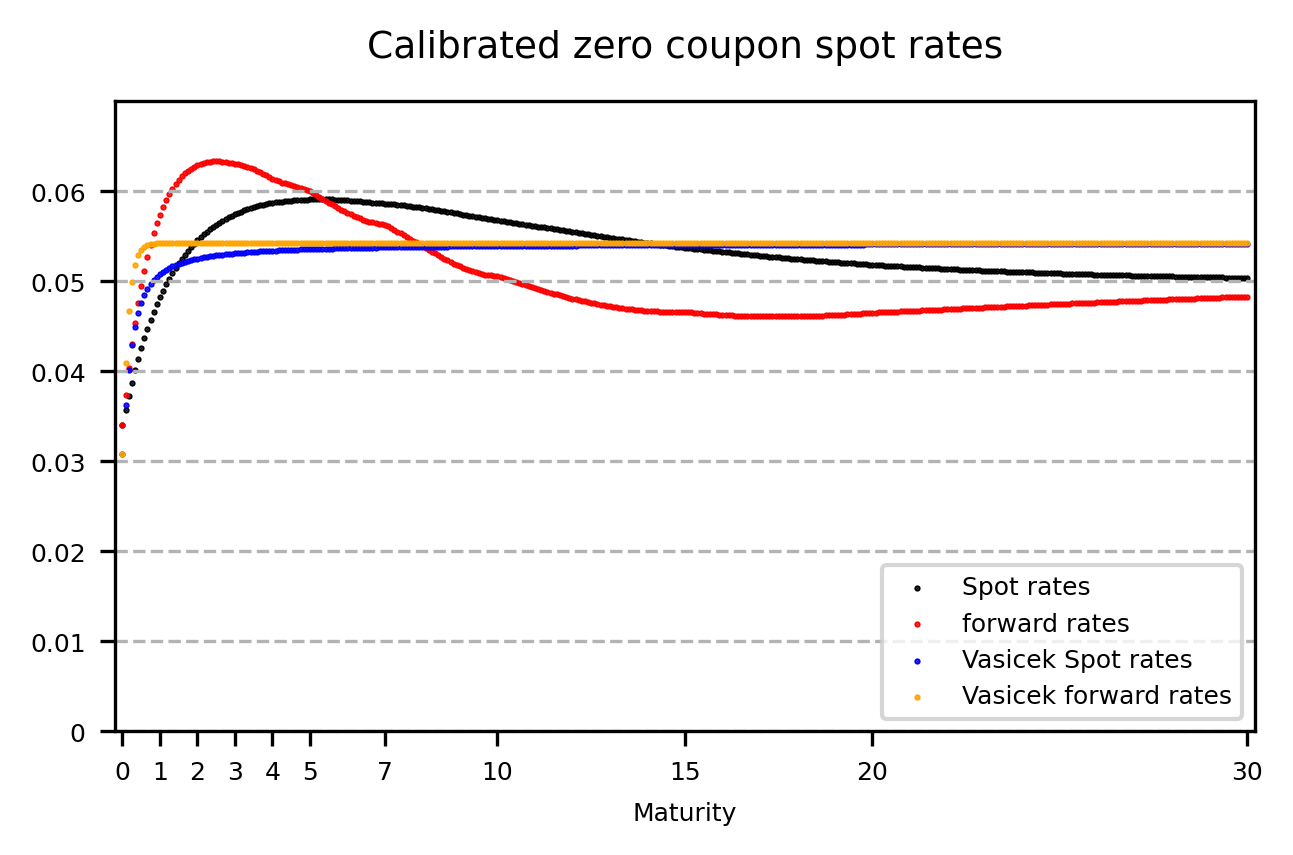

In [40]:
#3.c)
R_vasicek = spot_rate_vasicek(r0_fit,a_fit,b_fit,sigma_fit,T_inter)
f_vasicek = forward_rate_vasicek(r0_fit,a_fit,b_fit,sigma_fit,T_inter)
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax.set_ylim([0,0.07])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter, f_inter, s = 1, color = 'red', marker = ".",label="forward rates")
p4 = ax.scatter(T_inter, R_vasicek, s = 1, color = 'blue', marker = ".",label="Vasicek Spot rates")
p5 = ax.scatter(T_inter, f_vasicek, s = 1, color = 'orange', marker = ".",label="Vasicek forward rates")
plots = [p1,p2,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

In [41]:
#3.d)
#Vasicek model can only fit linear and monotonic yield curves.
#This yield curve is not monotonic, so the Vasicek model is not 
#a good fit for this yield curve.

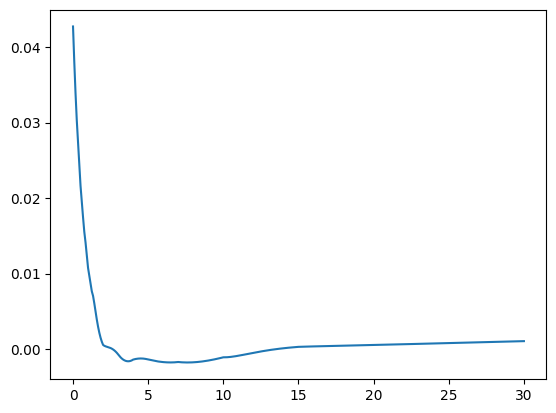

In [42]:
#4.a)
sigma = 0.005
f_fit = np.array(for_values_in_list_find_value_return_value(T_fit,T_inter,f_inter))
_, f_star = interpolate(T_inter, T_fit, f_fit, interpolation_options)
theta = theta_ho_lee(T_inter, sigma, "default", f_star)
plt.plot(T_inter,theta)
plt.show()

In [44]:
#4.b)
#The Ho-Lee model can fit any yield curve. Theta is dependent on time
#Therefore it can fit any yield curve.

In [45]:
#5.a)
a = 0.15
sigma = 0.01
#A caplet gives you the right to lock the rate at a certain level on some
#predetermined date in the future. This is the same as a european
#call option on a bond. 

In [53]:
#5.c)
T_caplet = np.array([i*0.5 for i in range(0,20 + 1)])
p_caplet = np.array(for_values_in_list_find_value_return_value(T_caplet, T_inter, p_inter))
caplet_prices = caplet_prices_ho_lee(0.06, sigma, T_caplet, p_caplet)
cap_price = np.sum(caplet_prices)
T_premium = np.array([i*0.25 for i in range(1,40 + 1)])
p_premium = np.array(for_values_in_list_find_value_return_value(T_premium, T_inter, p_inter))
premium = cap_price/np.sum(p_premium)
print(cap_price)
print(premium)

0.0554615968679158
0.0018377521502290011


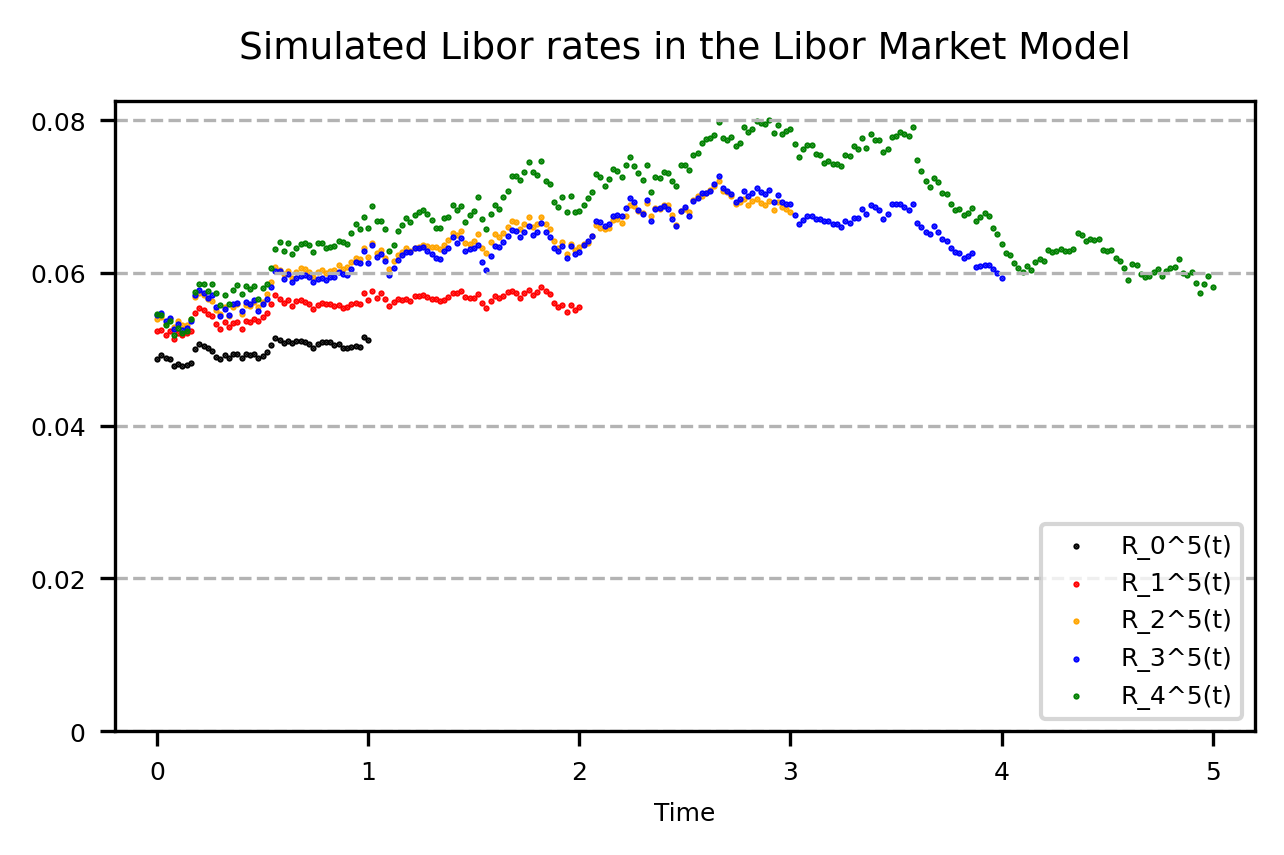

In [55]:


R = np.array([0.03544326, 0.04117089, 0.04464488, 0.04675195, 0.04802996])
sigma_swaption = np.array([0.072,0.084,0.102,0.119,0.141])
rho_swap = np.array([[1,0.95,0.9,0.85,0.8],[0.95,1,0.95,0.9,0.85],[0.9,0.95,1,0.95,0.9],[0.85,0.9,0.95,1,0.95],[0.8,0.85,0.9,0.95,1]])

# Problem 1
M, alpha = 6, 1
T = np.array([m*alpha for m in range(0,M)])
p = np.ones(M)
alpha = np.zeros(M)
sigma_lmm = np.ones(M)
for i in range(1,M):
    p[i] = np.exp(-R[i-1]*T[i])
    alpha[i] = T[i]-T[i-1]
R_swap = np.zeros(M-1)
for i in range(0,M-1):
    R_swap[i], af = swap_rate_from_zcb_prices(0,T[i],T[-1],"annual",T,p)

M_simul = 250
t_simul = np.array([i*T[-1]/M_simul for i in range(0,M_simul+1)])
R_simul = simul_smm(R_swap,T,sigma_swaption,rho_swap,M_simul)

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Simulated Libor rates in the Libor Market Model", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = np.array([0,1,2,3,4,5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Time",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(t_simul, R_simul[0,:], s = 1, color = 'black', marker = ".",label="R_0^5(t)")
p2 = ax.scatter(t_simul, R_simul[1,:], s = 1, color = 'red', marker = ".",label="R_1^5(t)")
p3 = ax.scatter(t_simul, R_simul[2,:], s = 1, color = 'orange', marker = ".",label="R_2^5(t)")
p4 = ax.scatter(t_simul, R_simul[3,:], s = 1, color = 'blue', marker = ".",label="R_3^5(t)")
p5 = ax.scatter(t_simul, R_simul[4,:], s = 1, color = 'green', marker = ".",label="R_4^5(t)")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()
